# KNN Hinge Loss - example

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader

In [5]:
from src.experiments import run_training_loop
from src.networks import CustomNeuralNetwork
from src.losses import KNNHingeLoss, HingeLoss
from src.utils import plot_values

In [6]:
# Load and normalize the trainig data
data = load_breast_cancer()
x, y = data['data'], data['target']
x = MinMaxScaler().fit_transform(x)

In [7]:
# Split data into train/test sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [8]:
x = torch.from_numpy(np.ascontiguousarray(x, dtype=np.float32))
y = torch.tensor(y.tolist(), dtype=torch.float32).reshape(-1, 1)

y[np.where(y == 0)] = -1

train_x = torch.from_numpy(np.ascontiguousarray(train_x, dtype=np.float32))
train_y = torch.tensor(train_y.tolist(), dtype=torch.float32).reshape(-1,1)

train_y[np.where(train_y == 0)] = -1

test_x = torch.from_numpy(np.ascontiguousarray(test_x, dtype=np.float32))
test_y = torch.tensor(test_y.tolist(), dtype=torch.float32).reshape(-1,1)

test_y[np.where(test_y == 0)] = -1

val_x = torch.from_numpy(np.ascontiguousarray(val_x, dtype=np.float32))
val_y = torch.tensor(val_y.tolist(), dtype=torch.float32).reshape(-1,1)

val_y[np.where(val_y == 0)] = -1

In [9]:
train_dataloader = DataLoader(TensorDataset(train_x, train_y), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(val_x, val_y), batch_size=32)
test_dataloader = DataLoader(TensorDataset(test_x, test_y), batch_size=1)

In [10]:
# Grid search
losses = [('HingeLoss', HingeLoss(), False)]

for k in [1, 3, 5]:
    for alpha in [0.3, 0.5, 0.7]:
        losses.append((f'KNNHingeLoss (K={k}/alpha={alpha})', KNNHingeLoss(x, y, k=k, alpha=alpha), True))

In [11]:
from tqdm import tqdm_notebook as tqdm

# Training loop
output_data = []

for lossname, lossfunc, knn_loss in losses:
    
    model = CustomNeuralNetwork(layers=[30, 16, 4, 1], hidden_activations="sigmoid", output_activations="sigmoid")
    optimizer = SGD(model.parameters(), lr=0.01)
    criterion = lossfunc
    
    model, train_loss, test_loss = run_training_loop(
        optimizer, 
        criterion, 
        model, 
        train_dataloader, 
        val_dataloader, 
        epochs=500, 
        use_wandb=False, 
        knn_loss=knn_loss, 
        tqdm_description=lossname
    )
    
    output_data.append((model, train_loss, test_loss))

KNNHingeLoss (K=5/alpha=0.7): 100%|██████████| 500/500 [00:11<00:00, 42.45it/s, val loss=1.75]


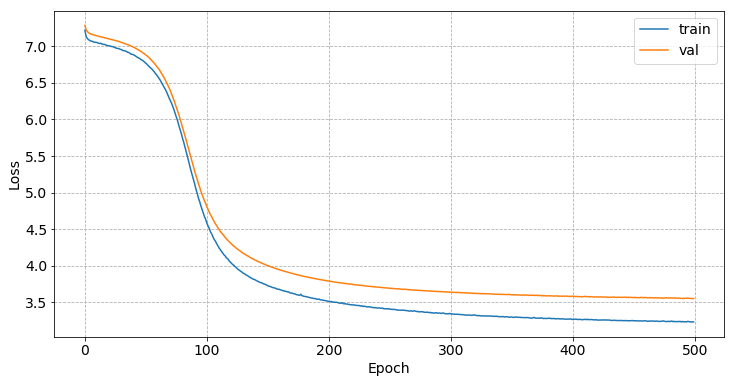

In [12]:
# Base line (HingeLoss)
model, tloss, vloss = output_data[0]
plot_values({'train': tloss, 'val': vloss})

/home/mikolaj/.virtualenvs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


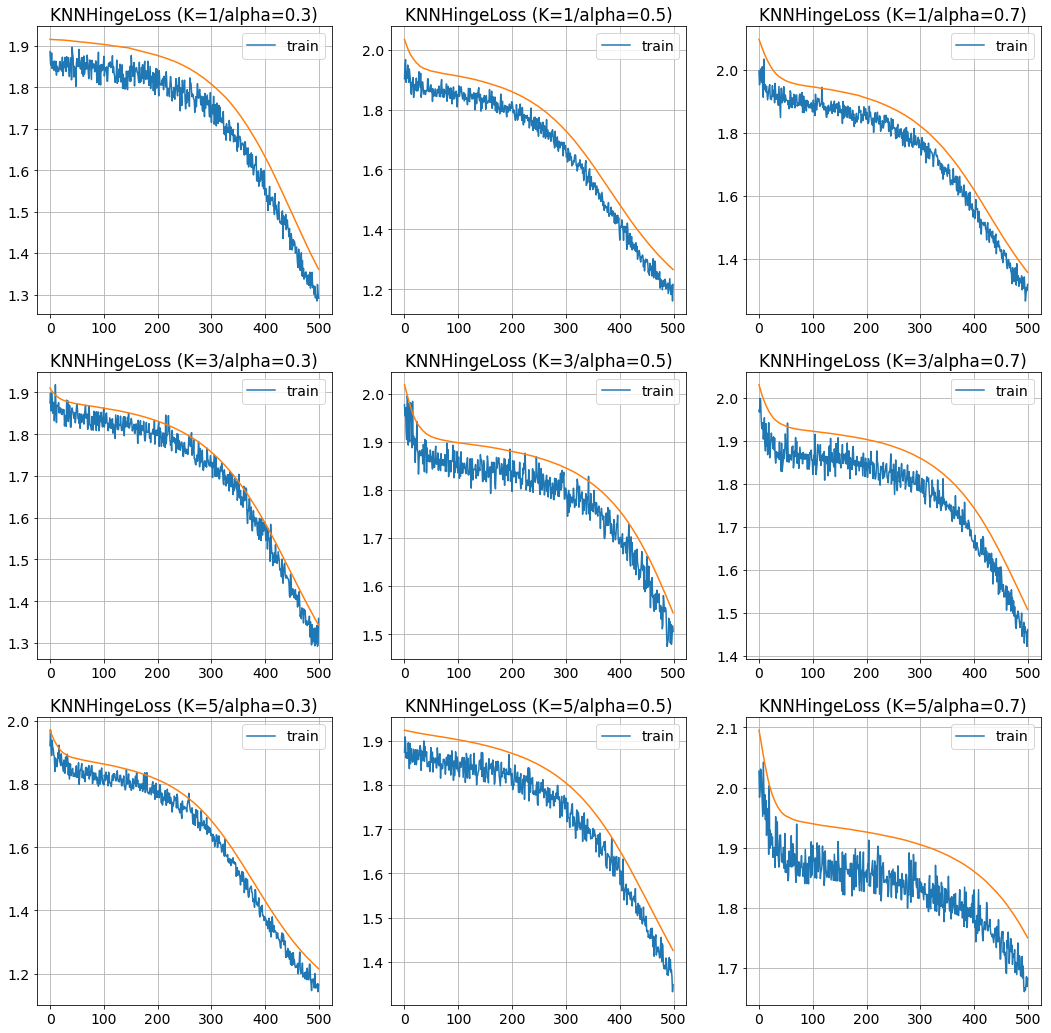

In [13]:
# KNN Hinge Loss
plt.figure(figsize=(18, 18))
for idx, (model, tloss, vloss) in enumerate(output_data[1:]):
    plt.subplot(3, 3, idx + 1)
    plt.grid('on')
    plt.plot(tloss, label='train')
    plt.plot(vloss)
    plt.legend()
    plt.title(losses[idx + 1][0])

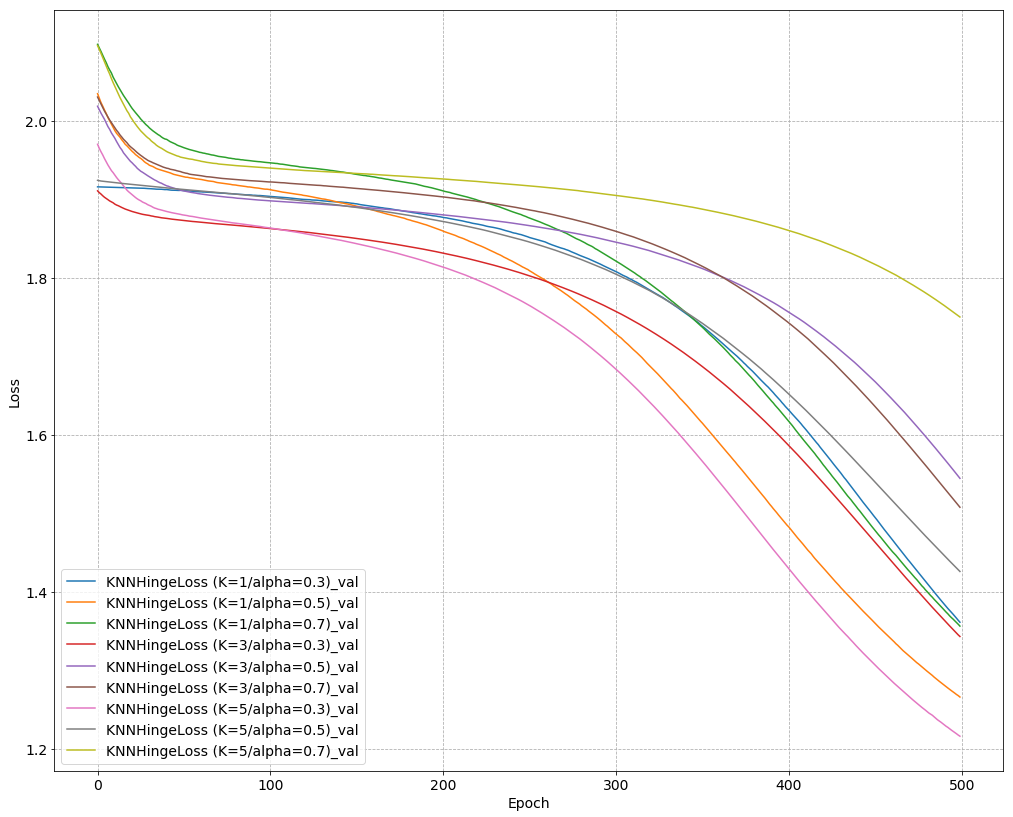

In [14]:
plot_all_data = {}
for idx, (model, tloss, vloss) in enumerate(output_data[1:]):
    plot_all_data[losses[idx + 1][0] + "_val"] = vloss
plot_values(plot_all_data, size=(17, 14))

In [15]:
# Evaluate output

evaluation_df = pd.DataFrame(columns=['name', 'acc', 'prec', 'recall', 'f1_score'])

for idx, (model, tloss, vloss) in enumerate(output_data):
    
    model_name = losses[idx][0]
    
    gt, predictions = [], []
    for data, label in test_dataloader:
        gt_label = max(label[0][0].item(), 0)
        gt.append(gt_label)
        with torch.no_grad():
            output = model(data)
        predictions.append(int(output.squeeze().item() > 0.5))
        
    evaluation_df = evaluation_df.append(
        pd.Series({
            'name': model_name,
            'acc': accuracy_score(gt, predictions),
            'prec': precision_score(gt, predictions),
            'recall': recall_score(gt, predictions),
            'f1_score': f1_score(gt, predictions)
        }),
        ignore_index=True
    )
    
evaluation_df

,name,acc,prec,recall,f1_score
0,HingeLoss,0.850877,0.982456,0.777778,0.868217
1,KNNHingeLoss (K=1/alpha=0.3),0.929825,0.984848,0.902778,0.942029
2,KNNHingeLoss (K=1/alpha=0.5),0.938596,0.985075,0.916667,0.949640
3,KNNHingeLoss (K=1/alpha=0.7),0.929825,0.984848,0.902778,0.942029
4,KNNHingeLoss (K=3/alpha=0.3),0.938596,1.000000,0.902778,0.948905
5,KNNHingeLoss (K=3/alpha=0.5),0.921053,1.000000,0.875000,0.933333
6,KNNHingeLoss (K=3/alpha=0.7),0.921053,1.000000,0.875000,0.933333
7,KNNHingeLoss (K=5/alpha=0.3),0.921053,0.970149,0.902778,0.935252
8,KNNHingeLoss (K=5/alpha=0.5),0.929825,0.984848,0.902778,0.942029
9,KNNHingeLoss (K=5/alpha=0.7),0.877193,0.983333,0.819444,0.893939
